# XKCD plots in Matplotlib

This notebook originally appeared as a blog post at [Pythonic Perambulations](http://jakevdp.github.com/blog/2012/10/07/xkcd-style-plots-in-matplotlib/) by Jake Vanderplas.

<!-- PELICAN_BEGIN_SUMMARY -->
*Update: the matplotlib pull request has been merged!  See*
[*This post*](http://jakevdp.github.io/blog/2013/07/10/XKCD-plots-in-matplotlib/)
*for a description of the XKCD functionality now built-in to matplotlib!*

One of the problems I've had with typical matplotlib figures is that everything in them is so precise, so perfect.  For an example of what I mean, take a look at this figure:

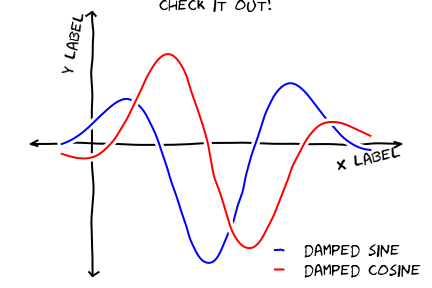

In [1]:
from IPython.display import Image
Image('http://jakevdp.github.com/figures/xkcd_version.png')

Sometimes when showing schematic plots, this is the type of figure I want to display.  But drawing it by hand is a pain: I'd rather just use matplotlib.  The problem is, matplotlib is a bit too precise.  Attempting to duplicate this figure in matplotlib leads to something like this:
<!-- PELICAN_END_SUMMARY -->

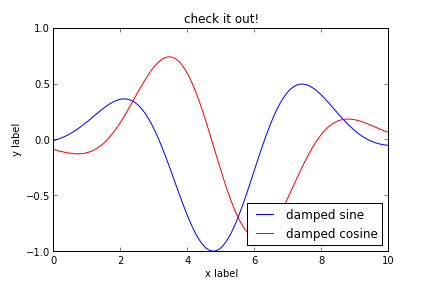

In [2]:
Image('http://jakevdp.github.com/figures/mpl_version.png')

It just doesn't have the same effect.  Matplotlib is great for scientific plots, but sometimes you don't want to be so precise.

This subject has recently come up on the matplotlib mailing list, and started some interesting discussions.
As near as I can tell, this started with a thread on a
[mathematica list](http://mathematica.stackexchange.com/questions/11350/xkcd-style-graphs)
which prompted a thread on the [matplotlib list](http://matplotlib.1069221.n5.nabble.com/XKCD-style-graphs-td39226.html)
wondering if the same could be done in matplotlib.

Damon McDougall offered a quick
[solution](http://www.mail-archive.com/matplotlib-users@lists.sourceforge.net/msg25499.html)
which was improved by Fernando Perez in [this notebook](http://nbviewer.ipython.org/3835181/), and
within a few days there was a [matplotlib pull request](https://github.com/matplotlib/matplotlib/pull/1329) offering a very general
way to create sketch-style plots in matplotlib.  Only a few days from a cool idea to a
working implementation: this is one of the most incredible aspects of package development on github.

The pull request looks really nice, but will likely not be included in a released version of
matplotlib until at least version 1.3.  In the mean-time, I wanted a way to play around with
these types of plots in a way that is compatible with the current release of matplotlib.  To do that,
I created the following code:

## The Code: XKCDify

XKCDify will take a matplotlib ``Axes`` instance, and modify the plot elements in-place to make
them look hand-drawn.
First off, we'll need to make sure we have the Humor Sans font.
It can be downloaded using the command below.

Next we'll create a function ``xkcd_line`` to add jitter to lines.  We want this to be very general, so
we'll normalize the size of the lines, and use a low-pass filter to add correlated noise, perpendicular
to the direction of the line.  There are a few parameters for this filter that can be tweaked to
customize the appearance of the jitter.

Finally, we'll create a function which accepts a matplotlib axis, and calls ``xkcd_line`` on
all lines in the axis.  Additionally, we'll switch the font of all text in the axes, and add
some background lines for a nice effect where lines cross.  We'll also draw axes, and move the
axes labels and titles to the appropriate location.

In [3]:
"""
XKCD plot generator
-------------------
Author: Jake Vanderplas

This is a script that will take any matplotlib line diagram, and convert it
to an XKCD-style plot.  It will work for plots with line & text elements,
including axes labels and titles (but not axes tick labels).

The idea for this comes from work by Damon McDougall
  http://www.mail-archive.com/matplotlib-users@lists.sourceforge.net/msg25499.html
"""
import numpy as np
import pylab as pl
from scipy import interpolate, signal
import matplotlib.font_manager as fm


# We need a special font for the code below.  It can be downloaded this way:
import os
import urllib2
if not os.path.exists('Humor-Sans.ttf'):
    fhandle = urllib2.urlopen('http://antiyawn.com/uploads/Humor-Sans-1.0.ttf')
    open('Humor-Sans.ttf', 'wb').write(fhandle.read())

    
def xkcd_line(x, y, xlim=None, ylim=None,
              mag=1.0, f1=30, f2=0.05, f3=15):
    """
    Mimic a hand-drawn line from (x, y) data

    Parameters
    ----------
    x, y : array_like
        arrays to be modified
    xlim, ylim : data range
        the assumed plot range for the modification.  If not specified,
        they will be guessed from the  data
    mag : float
        magnitude of distortions
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    
    Returns
    -------
    x, y : ndarrays
        The modified lines
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    # get limits for rescaling
    if xlim is None:
        xlim = (x.min(), x.max())
    if ylim is None:
        ylim = (y.min(), y.max())

    if xlim[1] == xlim[0]:
        xlim = ylim
        
    if ylim[1] == ylim[0]:
        ylim = xlim

    # scale the data
    x_scaled = (x - xlim[0]) * 1. / (xlim[1] - xlim[0])
    y_scaled = (y - ylim[0]) * 1. / (ylim[1] - ylim[0])

    # compute the total distance along the path
    dx = x_scaled[1:] - x_scaled[:-1]
    dy = y_scaled[1:] - y_scaled[:-1]
    dist_tot = np.sum(np.sqrt(dx * dx + dy * dy))

    # number of interpolated points is proportional to the distance
    Nu = int(200 * dist_tot)
    u = np.arange(-1, Nu + 1) * 1. / (Nu - 1)

    # interpolate curve at sampled points
    k = min(3, len(x) - 1)
    res = interpolate.splprep([x_scaled, y_scaled], s=0, k=k)
    x_int, y_int = interpolate.splev(u, res[0]) 

    # we'll perturb perpendicular to the drawn line
    dx = x_int[2:] - x_int[:-2]
    dy = y_int[2:] - y_int[:-2]
    dist = np.sqrt(dx * dx + dy * dy)

    # create a filtered perturbation
    coeffs = mag * np.random.normal(0, 0.01, len(x_int) - 2)
    b = signal.firwin(f1, f2 * dist_tot, window=('kaiser', f3))
    response = signal.lfilter(b, 1, coeffs)

    x_int[1:-1] += response * dy / dist
    y_int[1:-1] += response * dx / dist

    # un-scale data
    x_int = x_int[1:-1] * (xlim[1] - xlim[0]) + xlim[0]
    y_int = y_int[1:-1] * (ylim[1] - ylim[0]) + ylim[0]
    
    return x_int, y_int


def XKCDify(ax, mag=1.0,
            f1=50, f2=0.01, f3=15,
            bgcolor='w',
            xaxis_loc=None,
            yaxis_loc=None,
            xaxis_arrow='+',
            yaxis_arrow='+',
            ax_extend=0.1,
            expand_axes=False):
    """Make axis look hand-drawn

    This adjusts all lines, text, legends, and axes in the figure to look
    like xkcd plots.  Other plot elements are not modified.
    
    Parameters
    ----------
    ax : Axes instance
        the axes to be modified.
    mag : float
        the magnitude of the distortion
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    xaxis_loc, yaxis_log : float
        The locations to draw the x and y axes.  If not specified, they
        will be drawn from the bottom left of the plot
    xaxis_arrow, yaxis_arrow : str
        where to draw arrows on the x/y axes.  Options are '+', '-', '+-', or ''
    ax_extend : float
        How far (fractionally) to extend the drawn axes beyond the original
        axes limits
    expand_axes : bool
        if True, then expand axes to fill the figure (useful if there is only
        a single axes in the figure)
    """
    # Get axes aspect
    ext = ax.get_window_extent().extents
    aspect = (ext[3] - ext[1]) / (ext[2] - ext[0])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xspan = xlim[1] - xlim[0]
    yspan = ylim[1] - xlim[0]

    xax_lim = (xlim[0] - ax_extend * xspan,
               xlim[1] + ax_extend * xspan)
    yax_lim = (ylim[0] - ax_extend * yspan,
               ylim[1] + ax_extend * yspan)

    if xaxis_loc is None:
        xaxis_loc = ylim[0]

    if yaxis_loc is None:
        yaxis_loc = xlim[0]

    # Draw axes
    xaxis = pl.Line2D([xax_lim[0], xax_lim[1]], [xaxis_loc, xaxis_loc],
                      linestyle='-', color='k')
    yaxis = pl.Line2D([yaxis_loc, yaxis_loc], [yax_lim[0], yax_lim[1]],
                      linestyle='-', color='k')

    # Label axes3, 0.5, 'hello', fontsize=14)
    ax.text(xax_lim[1], xaxis_loc - 0.02 * yspan, ax.get_xlabel(),
            fontsize=14, ha='right', va='top', rotation=12)
    ax.text(yaxis_loc - 0.02 * xspan, yax_lim[1], ax.get_ylabel(),
            fontsize=14, ha='right', va='top', rotation=78)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add title
    ax.text(0.5 * (xax_lim[1] + xax_lim[0]), yax_lim[1],
            ax.get_title(),
            ha='center', va='bottom', fontsize=16)
    ax.set_title('')

    Nlines = len(ax.lines)
    lines = [xaxis, yaxis] + [ax.lines.pop(0) for i in range(Nlines)]

    for line in lines:
        x, y = line.get_data()

        x_int, y_int = xkcd_line(x, y, xlim, ylim,
                                 mag, f1, f2, f3)

        # create foreground and background line
        lw = line.get_linewidth()
        line.set_linewidth(2 * lw)
        line.set_data(x_int, y_int)

        # don't add background line for axes
        if (line is not xaxis) and (line is not yaxis):
            line_bg = pl.Line2D(x_int, y_int, color=bgcolor,
                                linewidth=8 * lw)

            ax.add_line(line_bg)
        ax.add_line(line)

    # Draw arrow-heads at the end of axes lines
    arr1 = 0.03 * np.array([-1, 0, -1])
    arr2 = 0.02 * np.array([-1, 0, 1])

    arr1[::2] += np.random.normal(0, 0.005, 2)
    arr2[::2] += np.random.normal(0, 0.005, 2)

    x, y = xaxis.get_data()
    if '+' in str(xaxis_arrow):
        ax.plot(x[-1] + arr1 * xspan * aspect,
                y[-1] + arr2 * yspan,
                color='k', lw=2)
    if '-' in str(xaxis_arrow):
        ax.plot(x[0] - arr1 * xspan * aspect,
                y[0] - arr2 * yspan,
                color='k', lw=2)

    x, y = yaxis.get_data()
    if '+' in str(yaxis_arrow):
        ax.plot(x[-1] + arr2 * xspan * aspect,
                y[-1] + arr1 * yspan,
                color='k', lw=2)
    if '-' in str(yaxis_arrow):
        ax.plot(x[0] - arr2 * xspan * aspect,
                y[0] - arr1 * yspan,
                color='k', lw=2)

    # Change all the fonts to humor-sans.
    prop = fm.FontProperties(fname='Humor-Sans.ttf', size=16)
    for text in ax.texts:
        text.set_fontproperties(prop)
    
    # modify legend
    leg = ax.get_legend()
    if leg is not None:
        leg.set_frame_on(False)
        
        for child in leg.get_children():
            if isinstance(child, pl.Line2D):
                x, y = child.get_data()
                child.set_data(xkcd_line(x, y, mag=10, f1=100, f2=0.001))
                child.set_linewidth(2 * child.get_linewidth())
            if isinstance(child, pl.Text):
                child.set_fontproperties(prop)
    
    # Set the axis limits
    ax.set_xlim(xax_lim[0] - 0.1 * xspan,
                xax_lim[1] + 0.1 * xspan)
    ax.set_ylim(yax_lim[0] - 0.1 * yspan,
                yax_lim[1] + 0.1 * yspan)

    # adjust the axes
    ax.set_xticks([])
    ax.set_yticks([])      

    if expand_axes:
        ax.figure.set_facecolor(bgcolor)
        ax.set_axis_off()
        ax.set_position([0, 0, 1, 1])
    
    return ax

## Testing it Out

Let's test this out with a simple plot.  We'll plot two curves, add some labels,
and then call ``XKCDify`` on the axis.  I think the results are pretty nice!

In [4]:
%pylab inline


Welcome to pylab, a matplotlib-based Python environment [backend: module://IPython.zmq.pylab.backend_inline].
For more information, type 'help(pylab)'.


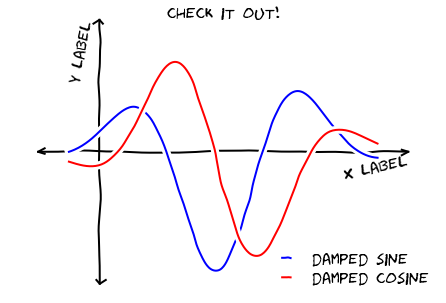

In [5]:
np.random.seed(0)

ax = pylab.axes()

x = np.linspace(0, 10, 100)
ax.plot(x, np.sin(x) * np.exp(-0.1 * (x - 5) ** 2), 'b', lw=1, label='damped sine')
ax.plot(x, -np.cos(x) * np.exp(-0.1 * (x - 5) ** 2), 'r', lw=1, label='damped cosine')

ax.set_title('check it out!')
ax.set_xlabel('x label')
ax.set_ylabel('y label')

ax.legend(loc='lower right')

ax.set_xlim(0, 10)
ax.set_ylim(-1.0, 1.0)

#XKCDify the axes -- this operates in-place
XKCDify(ax, xaxis_loc=0.0, yaxis_loc=1.0,
        xaxis_arrow='+-', yaxis_arrow='+-',
        expand_axes=True)


## Duplicating an XKCD Comic

Now let's see if we can use this to replicated an XKCD comic in matplotlib.
This is a good one:

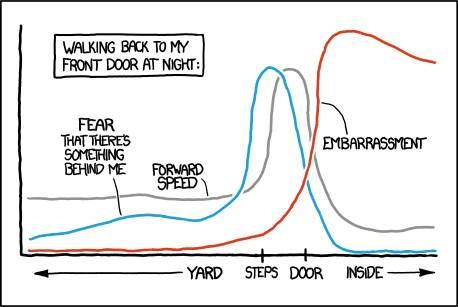

In [6]:
Image('http://imgs.xkcd.com/comics/front_door.png')

With the new ``XKCDify`` function, this is relatively easy to replicate.  The results
are not exactly identical, but I think it definitely gets the point across!

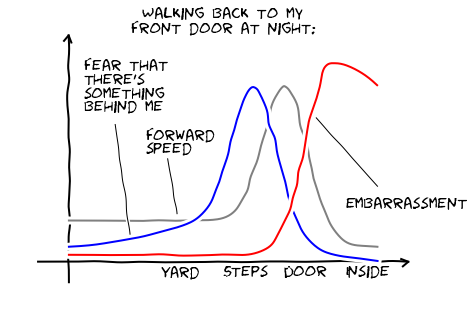

In [7]:
# Some helper functions
def norm(x, x0, sigma):
    return np.exp(-0.5 * (x - x0) ** 2 / sigma ** 2)

def sigmoid(x, x0, alpha):
    return 1. / (1. + np.exp(- (x - x0) / alpha))
    
# define the curves
x = np.linspace(0, 1, 100)
y1 = np.sqrt(norm(x, 0.7, 0.05)) + 0.2 * (1.5 - sigmoid(x, 0.8, 0.05))

y2 = 0.2 * norm(x, 0.5, 0.2) + np.sqrt(norm(x, 0.6, 0.05)) + 0.1 * (1 - sigmoid(x, 0.75, 0.05))

y3 = 0.05 + 1.4 * norm(x, 0.85, 0.08)
y3[x > 0.85] = 0.05 + 1.4 * norm(x[x > 0.85], 0.85, 0.3)

# draw the curves
ax = pl.axes()
ax.plot(x, y1, c='gray')
ax.plot(x, y2, c='blue')
ax.plot(x, y3, c='red')

ax.text(0.3, -0.1, "Yard")
ax.text(0.5, -0.1, "Steps")
ax.text(0.7, -0.1, "Door")
ax.text(0.9, -0.1, "Inside")

ax.text(0.05, 1.1, "fear that\nthere's\nsomething\nbehind me")
ax.plot([0.15, 0.2], [1.0, 0.2], '-k', lw=0.5)

ax.text(0.25, 0.8, "forward\nspeed")
ax.plot([0.32, 0.35], [0.75, 0.35], '-k', lw=0.5)

ax.text(0.9, 0.4, "embarrassment")
ax.plot([1.0, 0.8], [0.55, 1.05], '-k', lw=0.5)

ax.set_title("Walking back to my\nfront door at night:")

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.5)

# modify all the axes elements in-place
XKCDify(ax, expand_axes=True)


Pretty good for a couple hours's work!

I think the possibilities here are pretty limitless: this is going to be a hugely
useful and popular feature in matplotlib, especially when the sketch artist PR is mature
and part of the main package.  I imagine using this style of plot for schematic figures
in presentations where the normal crisp matplotlib lines look a bit too "scientific".
I'm giving a few talks at the end of the month... maybe I'll even use some of
this code there.

This post was written entirely in an IPython Notebook: the notebook file is available for
download [here](http://jakevdp.github.com/downloads/notebooks/XKCD_plots.ipynb).
For more information on blogging with notebooks in octopress, see my
[previous post](http://jakevdp.github.com/blog/2012/10/04/blogging-with-ipython/)
on the subject.